## 모델링 준비

In [2]:
# 라이브러리
from google.cloud import storage
import io
import pandas as pd
import gcsfs
import os

import json
import matplotlib.pyplot as plt
import seaborn as sns

### 테이블 불러오기

In [3]:
# 서비스 계정 키 경로
key_path = '/home/silverwest0822/Apache_Airflow/sprintda07-hyunseung-b549fc3c2f43.json'

# gcsfs 파일시스템 객체
fs = gcsfs.GCSFileSystem(token=key_path)

# 와일드카드로 GCS 파일 리스트 받기
file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/accounts_*.parquet')
print("찾은 파일들:", file_list)

# 파일별 DataFrame을 저장할 딕셔너리
votes_ac = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_ac[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

찾은 파일들: ['sprintda07-hyunseung/dataset/votes/accounts_attendance.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_blockrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_failpaymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_friendrequest.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_group.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_nearbyschool.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_paymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_pointhistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_school.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_timelinereport.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user_contacts.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userquestionrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userwithdraw.parquet']
✅ accounts_attendance → shape: (349637, 3)
✅ 

In [237]:
# event

file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/event*.parquet')

votes_ev = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_ev[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

✅ event_receipts → shape: (309, 5)
✅ events → shape: (3, 6)


In [4]:
# polls

file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/polls_*.parquet')

votes_po = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_po[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

✅ polls_question → shape: (5025, 3)
✅ polls_questionpiece → shape: (1265476, 5)
✅ polls_questionreport → shape: (51424, 5)
✅ polls_questionset → shape: (158384, 6)
✅ polls_usercandidate → shape: (4769609, 4)


### 테이블 꺼내고 기간 필터링

In [5]:
# 8/7 테이블 불러오기 (이거 시간있을때 자동화좀... 보기 너무 안좋아)
accounts_user = votes_ac['accounts_user'].copy()
accounts_attendance = votes_ac['accounts_attendance'].copy()
accounts_blockrecord = votes_ac['accounts_blockrecord'].copy()
accounts_paymenthistory = votes_ac['accounts_paymenthistory'].copy()
polls_questionreport = votes_po['polls_questionreport'].copy()
polls_usercandidate = votes_po['polls_usercandidate'].copy()

polls_questionset = votes_po['polls_questionset'].copy()
accounts_userquestionrecord = votes_ac['accounts_userquestionrecord'].copy()
accounts_school = votes_ac['accounts_school'].copy()
accounts_group = votes_ac['accounts_group'].copy()

In [6]:
# accounts_user 
# gender, group_id 결측치 제거 : 3건 제거
accounts_user = accounts_user.dropna()

# staff인 건 제거 : 1건 제거 (staff 3명인데 2명이 gender 결측치 있었음)
accounts_user = accounts_user[accounts_user['is_staff'] != 1]

In [8]:
# 필터링 기간
dfs = [('accounts_user', accounts_user), ('accounts_blockrecord', accounts_blockrecord), 
       ('accounts_paymenthistory', accounts_paymenthistory), 
       ('polls_questionreport', polls_questionreport), ('polls_usercandidate', polls_usercandidate)]

start_date = pd.to_datetime("2023-05-13")
end_date   = pd.to_datetime("2023-08-31")

for name, df in dfs:
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    globals()[name] = filtered_df.reset_index(drop=True)

### 파생변수 생성 및 중복행 제거

In [9]:
# 출석일수 attendance_cnt
accounts_attendance['attendance_cnt'] = accounts_attendance['attendance_date_list'].apply(lambda x: len(json.loads(x)))

# 차단한 유저 수 block_cnt
accounts_blockrecord['block_cnt'] = accounts_blockrecord.groupby('user_id')['block_user_id'].transform('count')

# 상품 구매 횟수 pay_cnt
accounts_paymenthistory['pay_cnt'] = accounts_paymenthistory.groupby('user_id')['productId'].transform('count')

# 생성한 질문세트 갯수 questionset_cnt
polls_questionset['questionset_cnt'] = polls_questionset.groupby('user_id').transform('size')

# 투표 횟수 vote_cnt
accounts_userquestionrecord['vote_cnt'] = accounts_userquestionrecord.groupby('user_id').transform('size')

In [10]:
# 집계된 테이블들 한 번 저장
user = accounts_user.copy()
attendance = accounts_attendance.copy()
blockrecord = accounts_blockrecord.copy()
paymenthis = accounts_paymenthistory.copy()
questionset = polls_questionset.copy()
questionrcd = accounts_userquestionrecord.copy()

In [11]:
# 중복행 제거
for df in [blockrecord, paymenthis, questionset, questionrcd]:
    df.drop_duplicates(subset=['user_id'], inplace=True)

In [12]:
# 병합 전 테이블 shape
dfs = [user, attendance, blockrecord, paymenthis]

for df in dfs:
    print(df.shape)

(355294, 16)
(349637, 4)
(10165, 6)
(58523, 6)


### 테이블 병합

In [13]:
# 기준 테이블 id → user_id 변경
user = user.rename(columns={'id': 'user_id'})

# 병합할 테이블, 조인 키, 가져올 컬럼 지정
tables_to_merge = [
    (blockrecord, 'user_id', ['block_cnt']),
    (paymenthis, 'user_id', ['pay_cnt']),
    (attendance, 'user_id', ['attendance_cnt']),
    (questionset, 'user_id', ['questionset_cnt']),
    (questionrcd, 'user_id', ['vote_cnt']),
]

for df, key, cols in tables_to_merge:
    # 필요한 컬럼만 선택
    temp = df[[key] + cols].drop_duplicates(subset=[key])

    # key가 'user_id'가 아니면 통일
    if key != 'user_id':
        temp = temp.rename(columns={key: 'user_id'})

    # 이미 user에 존재하는 컬럼 제거 (중복 방지)
    duplicate_cols = set(temp.columns) & set(user.columns) - {'user_id'}
    if duplicate_cols:
        user = user.drop(columns=duplicate_cols)

    # 병합
    user = user.merge(temp, on='user_id', how='left')

# 결측치는 0으로 채우기 (숫자 컬럼만)
num_cols = user.select_dtypes(include=['number']).columns
user[num_cols] = user[num_cols].fillna(0)

# 결과 확인
print(user.head())

   user_id  is_superuser  is_staff gender  point  \
0   855179             0         0      M   1358   
1   866522             0         0      F   2429   
2   916697             0         0      M    441   
3   920278             0         0      F    991   
4   921725             0         0      F    839   

                                      friend_id_list  is_push_on  \
0   [849767, 850569, 857770, 856249, 850108, 869470]           1   
1  [863744, 880135, 857608, 865290, 860687, 86376...           1   
2  [890753, 921090, 936709, 1035016, 1081352, 972...           1   
3  [1452418, 935043, 982406, 1106183, 948743, 935...           0   
4  [900514, 924484, 992548, 934887, 946027, 92718...           0   

                  created_at block_user_id_list hide_user_id_list  ...  \
0 2023-05-18 16:36:23.667542                 []                []  ...   
1 2023-05-18 16:32:15.932829                 []                []  ...   
2 2023-05-18 16:11:30.841506          [1165931]         

In [16]:
# 테이블 병합 후 처리

# 1) pending_chat -1인 4건 제거
user = user[user['pending_chat'] != -1]

# 2) 미출석 유저 제거 => 미투표, 질문미생성 미삭제
user = user[user['attendance_cnt'] != 0] # 미출석 160278건

In [17]:
# 안 쓸 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff', 'created_at', 'friend_id_list',
                          'block_user_id_list', 'hide_user_id_list', 'group_id'])

In [46]:
user = user.drop(columns=['gender'])

In [48]:
user = user.drop(columns=['questionset_cnt'])

* 마스터에서 비활성 유저 제거(출석 안함, 질문 안함, 투표 안함) => 서비스 핵심 기능을 사용하지 않은 유저로 정의
1. 출석 일수 0일
    - accounts_attendance[accounts_attendance['attendance_cnt'] == 0]
2. 투표 횟수 0회
    - accounts_userquestionrecord[accounts_userquestionrecord['vote_cnt'] == 0]
3. 생성한 질문세트 갯수 0개
    - polls_questionset[polls_questionset['questionset_cnt'] == 0]
> 2, 3을 제거하면 너무 많은 양의 데이터가 날아감 + 서비스 다른 기능을 이용했을 수 있으므로 제거하지 않고 진행함

4. 학생수 0명 (기존 테이블에서 집계했을 때는 388건, group_id와 grade도 결측치인 것들임)
    - school_group[school_group['student_count'] == 0]

In [18]:
user.shape

(194630, 14)

In [19]:
user.describe()

,user_id,point,is_push_on,report_count,alarm_count,pending_chat,pending_votes,block_cnt,pay_cnt,attendance_cnt,questionset_cnt,vote_cnt
count,1.946300e+05,1.946300e+05,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000,194630.000000
mean,1.396109e+06,2.017939e+03,0.862303,0.040271,0.807101,0.117402,55.969722,0.032621,0.232385,7.084175,0.199286,1.512038
std,1.124904e+05,2.279115e+04,0.344583,0.428920,1.045207,4.162461,99.623391,0.316609,0.868036,9.339533,3.550034,28.217945
min,1.106970e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.300632e+06,4.210000e+02,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,1.403246e+06,1.138000e+03,1.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,1.494990e+06,2.614000e+03,1.000000,0.000000,1.000000,0.000000,67.000000,0.000000,0.000000,9.000000,0.000000,0.000000
max,1.580265e+06,9.988541e+06,1.000000,71.000000,201.000000,1801.000000,2744.000000,39.000000,60.000000,310.000000,202.000000,1695.000000


## 모델링

### 변수 상태 확인
1. 변수 간 다중공선성 확인
2. 변수 분포 확인
3. 이상치 확인

In [50]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 연속형 변수만
X = user[['point', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes',
          'block_cnt', 'pay_cnt', 'attendance_cnt']] 

# 상수항 추가 (VIF 계산시 필요)
X_with_const = sm.add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_with_const.values, i+1)  # const 제외
                 for i in range(len(X.columns))]

print(vif_df)


         variable       VIF
0           point  1.245200
1    report_count  1.158370
2     alarm_count  1.255798
3    pending_chat  1.159592
4   pending_votes  1.015645
5       block_cnt  1.000853
6         pay_cnt  1.004063
7  attendance_cnt  1.031104


In [51]:
user.columns

Index(['user_id', 'point', 'is_push_on', 'ban_status', 'report_count',
       'alarm_count', 'pending_chat', 'pending_votes', 'block_cnt', 'pay_cnt',
       'attendance_cnt', 'vote_cnt'],
      dtype='object')

In [54]:
# 범주형 잠시 제거 
test = user.drop(columns=['ban_status', 'is_push_on'])

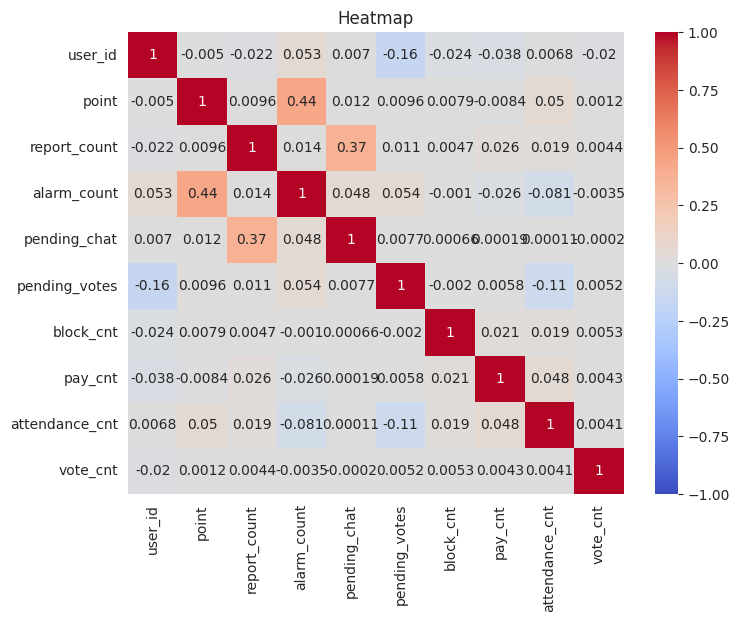

In [55]:
# 변수 간 상관계수 행렬 계산
corr_matrix = test.corr()

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap')
plt.show()

> 시각화를 통해 알 수 있는 부분
1. 출석 일수가 많을수록 포인트가 많을것임. (VIF에서도 두 변수가 상대적으로 높은 VIF 값을 가졌음)
2. 쌓인 투표수가 많을수록 보유 포인트가 많음. (두 변수는 연결지어 활발하게 이용하는 유저의 척도로서 볼 수 있을듯 함)

### 모델링 전 전처리
1. user_id 제거
2. 스케일링

In [32]:
# 라이브러리
import numpy as np
from sklearn.cluster import (KMeans, DBSCAN)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)

In [59]:
# master 원본 보존
cleaned = user.copy()

In [ ]:
# user_id 제거
cleaned = cleaned.drop(columns=['user_id'])

# gender, ban_status 원핫 인코딩
cleaned = pd.get_dummies(cleaned, columns=['ban_status'])

# 로그 변환 (count 변수들에 대해서)

log_vars = [
    'point', 'report_count', 'alarm_count', 
    'pending_chat', 'pending_votes', 'block_cnt', 
    'pay_cnt', 'attendance_cnt'
]

# 로그 변환
cleaned[log_vars] = cleaned[log_vars].apply(lambda x: np.log1p(x))

# 정규화
ss = StandardScaler()
scaled_df = pd.DataFrame(
    ss.fit_transform(cleaned),
    columns=cleaned.columns
)

1. 차원축소 전

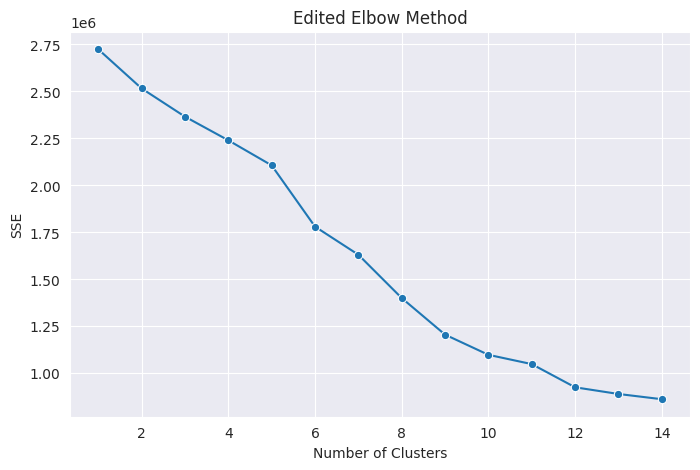

In [61]:
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Edited Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [62]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(scaled_df) # 학습
labels = kmeans.predict(scaled_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(scaled_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    65819
1    24795
2    87623
3    13597
4     2348
5      448
Name: count, dtype: int64

In [63]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3,4,5
point,-0.115072,-0.001791,0.067189,0.148251,-0.155189,0.177708
is_push_on,0.399607,-2.502461,0.399607,0.088846,-0.191189,-0.060319
report_count,0.050549,-0.031302,-0.034734,0.039007,-0.041998,0.135648
alarm_count,-0.613391,0.045949,0.436139,0.214588,-0.795517,-0.072033
pending_chat,-0.257923,-0.243287,-0.258103,3.353500,0.015593,-0.022161
pending_votes,-0.693702,-0.145893,0.517599,0.384112,-0.562728,0.047145
block_cnt,0.055596,0.000083,-0.049789,0.029512,0.093482,0.179894
pay_cnt,0.154939,-0.034848,-0.108655,0.024747,-0.090835,0.142098
attendance_cnt,0.610272,0.059344,-0.471898,0.009624,-0.212943,0.177027
vote_cnt,-0.044067,-0.036809,-0.040644,-0.045567,-0.031865,18.010891


2. 차원 축소 후

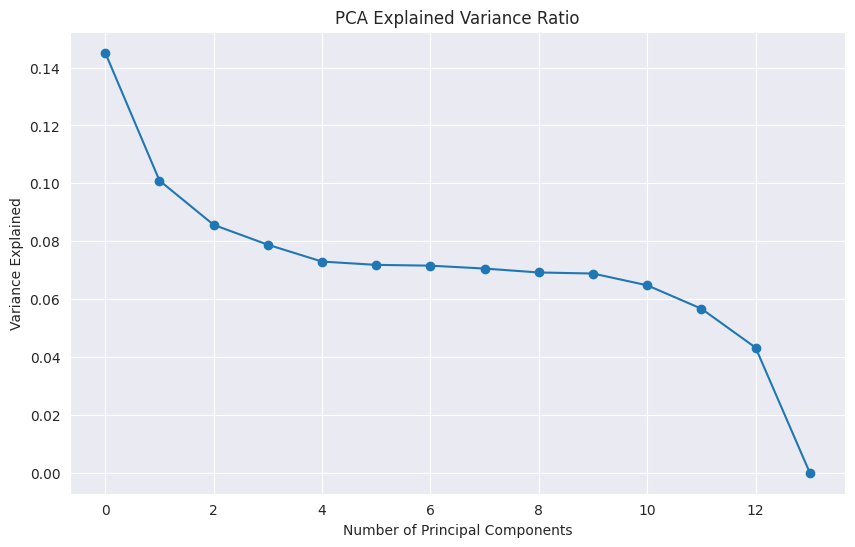

In [64]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
scaled_data_pca = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(scaled_data_pca)

# Scree Plot
num_components = len(pca.explained_variance_ratio_)

x = np.arange(num_components)
var = pca.explained_variance_ratio_

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [65]:
X = scaled_df.copy()

pca = PCA(n_components=2)
x_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])

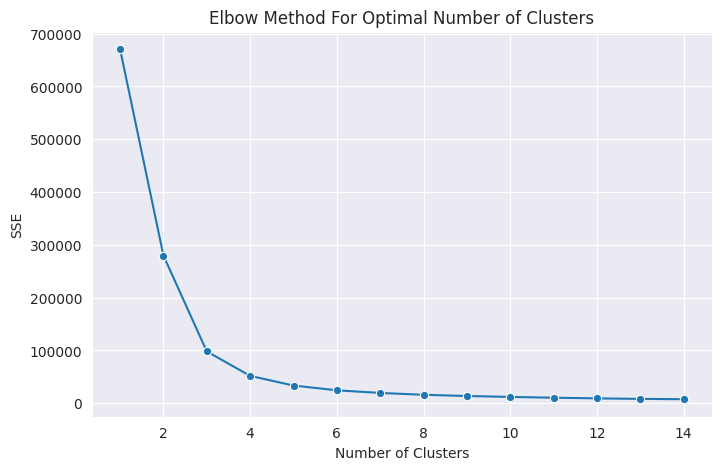

In [66]:
# 최적의 k 찾기 위한 elbow method 시각화
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(pca_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [67]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df) # 학습
labels = kmeans.predict(pca_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(pca_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    46820
1    82706
2     2355
3    62749
Name: count, dtype: int64

In [68]:
kmeans_data.columns

Index(['point', 'is_push_on', 'report_count', 'alarm_count', 'pending_chat',
       'pending_votes', 'block_cnt', 'pay_cnt', 'attendance_cnt', 'vote_cnt',
       'ban_status_N', 'ban_status_NB', 'ban_status_RB', 'ban_status_W',
       'labels'],
      dtype='object')

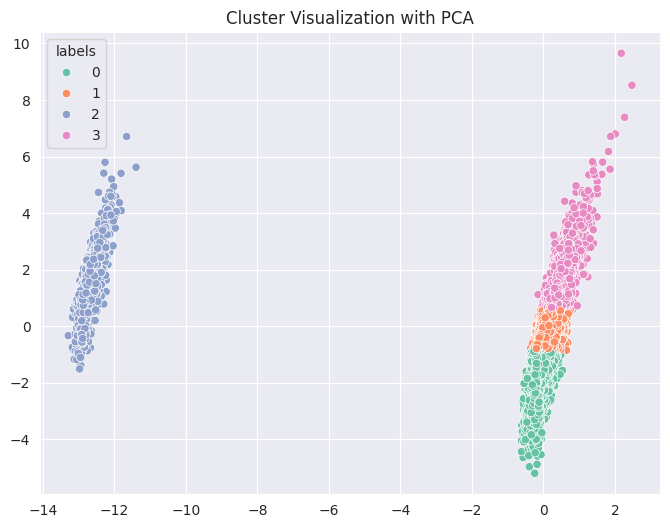

In [69]:
X_numeric = kmeans_data.drop(columns=['labels'])
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_numeric)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_data['labels'], palette='Set2')
plt.title('Cluster Visualization with PCA')
plt.show()

In [70]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3
point,-0.279657,-0.018118,-0.154684,0.238352
is_push_on,-0.086964,-0.015180,-0.190665,0.092052
report_count,0.078527,-0.005822,-0.042325,-0.049330
alarm_count,-0.947785,0.078590,-0.795625,0.633462
pending_chat,-0.192447,-0.102606,0.014780,0.278279
pending_votes,-0.885507,-0.138525,-0.559744,0.864308
block_cnt,0.121091,-0.012977,0.099522,-0.076983
pay_cnt,0.335217,-0.029860,-0.089625,-0.207400
attendance_cnt,0.817333,0.011211,-0.211742,-0.616681
vote_cnt,0.023972,0.000334,0.016962,-0.018963


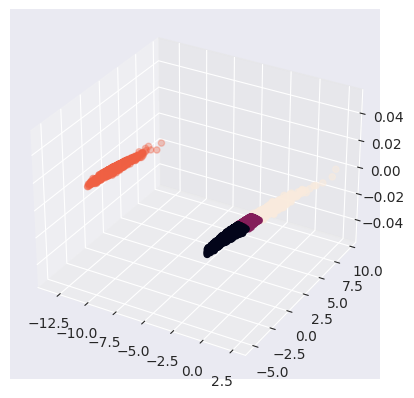

In [71]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], c=labels)

In [72]:
import pandas as pd

# df: feature dataframe, labels: 클러스터 라벨
cluster_means = kmeans_data.groupby(labels).mean()
cluster_diff = cluster_means.max() - cluster_means.min()
important_features = cluster_diff.sort_values(ascending=False)
print(important_features)

ban_status_N      9.146457
ban_status_W      9.089282
labels            3.000000
pending_votes     1.749816
alarm_count       1.581247
attendance_cnt    1.434014
ban_status_RB     0.973478
pay_cnt           0.542617
point             0.518009
pending_chat      0.470725
is_push_on        0.282717
ban_status_NB     0.264930
block_cnt         0.198074
report_count      0.127858
vote_cnt          0.042934
dtype: float64


In [ ]:
import pandas as pd

# 영향도 시리즈
importance = pd.Series({
ban_status_N      9.146457,
ban_status_W      9.089282,
labels            3.000000
pending_votes     1.749816
alarm_count       1.581247
attendance_cnt    1.434014
ban_status_RB     0.973478
pay_cnt           0.542617
point             0.518009
pending_chat      0.470725
is_push_on        0.282717
ban_status_NB     0.264930
block_cnt         0.198074
report_count      0.127858
vote_cnt          0.042934
})

# 변수 그룹핑
grouped = {
    'ban_status': ['ban_status_N','ban_status_W','ban_status_RB','ban_status_NB'],
}

# 합치기
grouped_importance = {}
for g, cols in grouped.items():
    grouped_importance[g] = importance[cols].sum()

# 나머지 개별 변수
others = [col for col in importance.index if not any(col in v for v in grouped.values())]
for col in others:
    grouped_importance[col] = importance[col]

# 정렬
grouped_importance = pd.Series(grouped_importance).sort_values(ascending=False)
print(grouped_importance)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1466167827.py, line 5)

In [74]:
import numpy as np
from sklearn.metrics import silhouette_score

# 샘플링 (최대 10,000개)
sample_idx = np.random.choice(len(pca_df), size=10000, replace=False)

# .iloc로 행 선택
sil_score = silhouette_score(pca_df.iloc[sample_idx], np.array(labels)[sample_idx])

print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.526


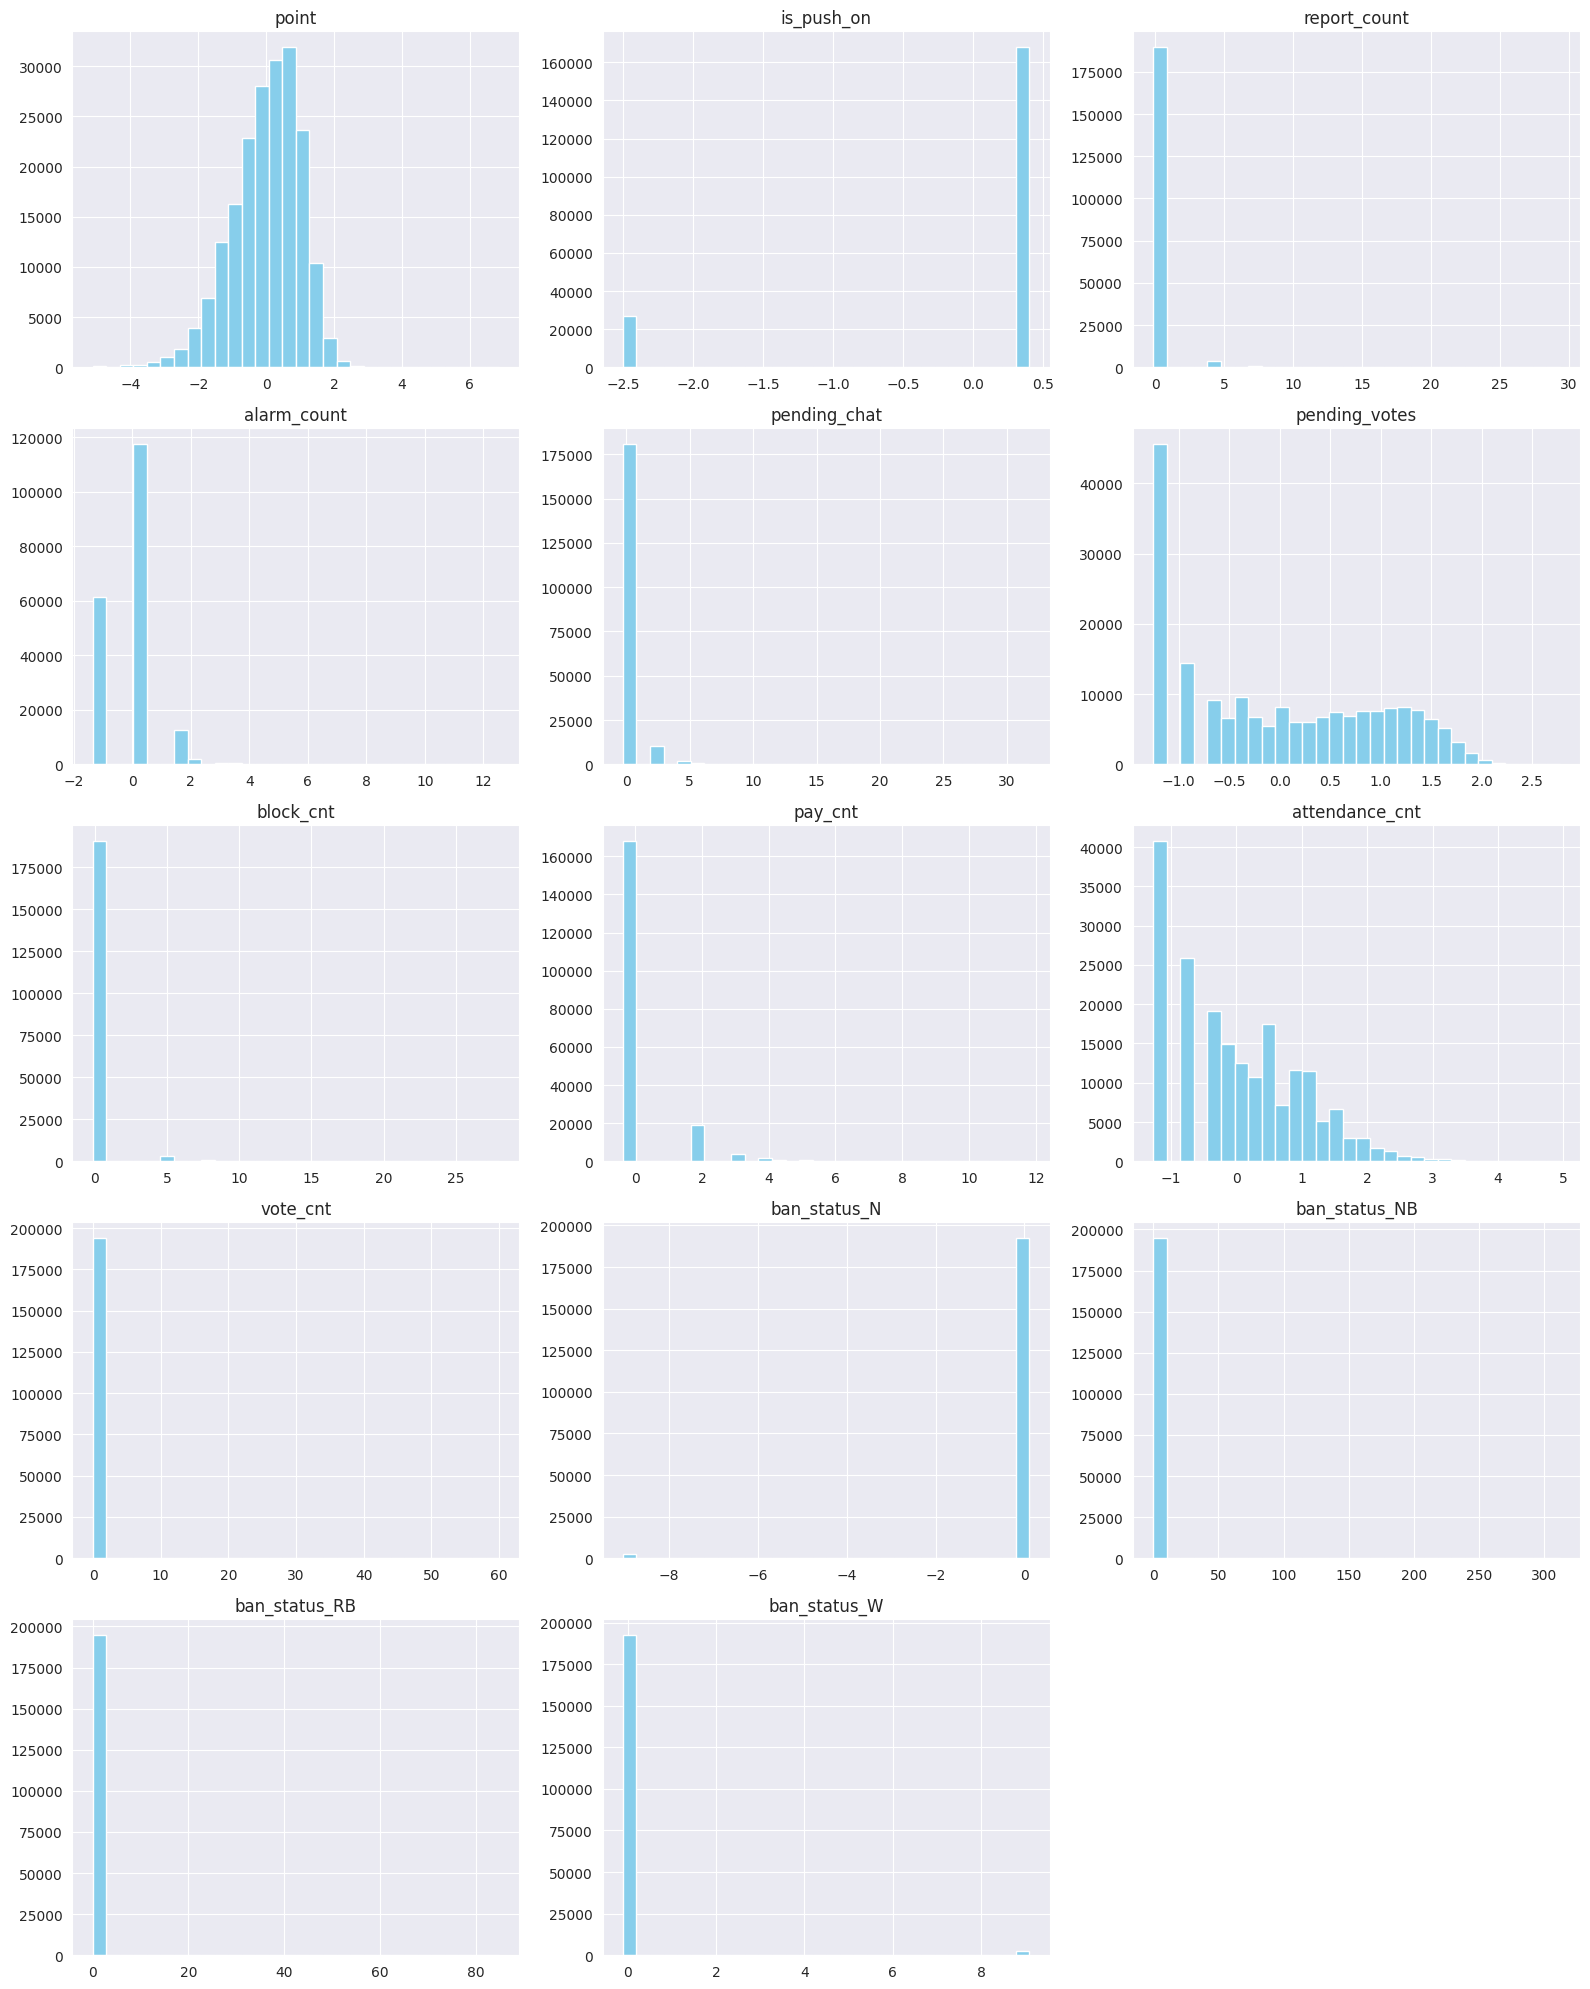

In [75]:
num_cols = scaled_df.select_dtypes(include=['float', 'int']).columns

# 한 행에 3개씩 뿌릴 subplot 크기 계산
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

for i, col in enumerate(num_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].hist(scaled_df[col], bins=30, color='skyblue')    
    axes[row, col_idx].set_title(col)

# 빈 서브플롯은 감추기
for i in range(len(num_cols), n_rows * n_cols):
    row = i // n_cols
    col_idx = i % n_cols
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.show()